In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cPickle as pickle

plt.rcParams["figure.figsize"] = (20,10)

%matplotlib inline

In [3]:
color_dict = {
    1610612737: ('#E13A3E', 'ATL'),
    1610612738: ('#008348', 'BOS'),
    1610612751: ('#061922', 'BKN'),
    1610612766: ('#1D1160', 'CHA'),
    1610612741: ('#CE1141', 'CHI'),
    1610612739: ('#860038', 'CLE'),
    1610612742: ('#007DC5', 'DAL'),
    1610612743: ('#4D90CD', 'DEN'),
    1610612765: ('#006BB6', 'DET'),
    1610612744: ('#FDB927', 'GSW'),
    1610612745: ('#CE1141', 'HOU'),
    1610612754: ('#00275D', 'IND'),
    1610612746: ('#ED174C', 'LAC'),
    1610612747: ('#552582', 'LAL'),
    1610612763: ('#0F586C', 'MEM'),
    1610612748: ('#98002E', 'MIA'),
    1610612749: ('#00471B', 'MIL'),
    1610612750: ('#005083', 'MIN'),
    1610612740: ('#002B5C', 'NOP'),
    1610612752: ('#006BB6', 'NYK'),
    1610612760: ('#007DC3', 'OKC'),
    1610612753: ('#007DC5', 'ORL'),
    1610612755: ('#006BB6', 'PHI'),
    1610612756: ('#1D1160', 'PHX'),
    1610612757: ('#E03A3E', 'POR'),
    1610612758: ('#724C9F', 'SAC'),
    1610612759: ('#BAC3C9', 'SAS'),
    1610612761: ('#000000', 'TOR'),
    1610612762: ('#00471B', 'UTA'),
    1610612764: ('#002B5C', 'WAS'),
}

In [83]:
# gameid='0021500188'
gameid = '0021500477'

# directories
# CHANGE HERE
data_dir = 'raptors/'
game_dir = data_dir+'data/'
court_path = data_dir + 'nba_court_T.png'


#open the pickle file
with open(game_dir+gameid+'.pkl', 'rb') as handle:
    datta = pickle.load(handle)

In [84]:
def draw_court(ii, jj):
    num_events = len(datta['events'])

    player_fields = datta['events'][0]['home']['players'][0].keys()
    # CHANGE THIS
    # specify an event number

    home_players = pd.DataFrame(data=[i for i in datta['events'][0]['home']['players']], columns=player_fields)
    away_players = pd.DataFrame(data=[i for i in datta['events'][0]['visitor']['players']], columns=player_fields)
    players = pd.merge(home_players, away_players, how='outer')
    jerseydict = dict(zip(players.playerid.values, players.jersey.values))

    # get the position of the players and the ball throughout the event
    ball_xy = np.array([x[5][0][2:5] for x in datta['events'][ii]['moments']]) #create matrix of ball data
    player_xy = np.array([np.array(x[5][1:])[:,:4] for x in datta['events'][ii]['moments']]) #create matrix of player data

    # get the play by play data for this clip
    playbyplay = datta['events'][ii]['playbyplay']
    team_1_xy_mean = -np.ones((len(player_xy),2))
    team_2_xy_mean = -np.ones((len(player_xy),2))


    # CHANGE THIS
    # plot a certain frame:
    #jj = (len(player_xy) - 1) / 2

    print('event ' + str(ii) + '/' + str(num_events) + ", moment: "+ str(jj) + '/'+ str(len(player_xy)))
    fig = plt.figure()
    ax = plt.gca() #create axis object


    img = mpimg.imread(court_path)  # read image. I got this image from gmf05's github.

    plt.imshow(img, extent=[0,94,0,50], zorder=0)  # show the image.

    # get player and ball data for the momenet
    ball = ball_xy[jj]
    player = player_xy[jj]


    # plot clock info
    clock_info = ax.annotate('', xy=[94.0/2 - 6.0/1.5 +0.1, 50 - 6.0/1.5 -0.35],
        color='black', horizontalalignment='center', verticalalignment='center')

    if not datta['events'][ii]['moments'][jj][0] == None:
        quarter = datta['events'][ii]['moments'][jj][0]
    else:
        quarter = 0

    if not datta['events'][ii]['moments'][jj][2] == None:
        game_clock = datta['events'][ii]['moments'][jj][2]
    else:
        game_clock = 0

    if not datta['events'][ii]['moments'][jj][3] == None:
        game_shot = datta['events'][ii]['moments'][jj][3]
    else:
        game_shot = 0

    clock_test = 'Quarter {:d}\n {:02d}:{:02d}\n {:03.1f}'.format(
        quarter,
        int(game_clock) % 3600 // 60,
        int(game_clock) % 60,
        game_shot)
    clock_info.set_text(clock_test)

    # the event title
    temp = str(datta['events'][ii]['home']['abbreviation'])+\
        ' vs. ' + str(datta['events'][ii]['visitor']['abbreviation'])+\
        '\n'
    for idx, pp in playbyplay.iterrows():
        temp = temp + str(pp['HOMEDESCRIPTION'])+ " , " +\
                str(pp['VISITORDESCRIPTION'])+ " , "+\
                str(pp['PCTIMESTRING'])+ " , "+\
                str(pp['event_str'])  + '\n'


    plt.title(temp)

    for kk in range(player.shape[0]): #create circle object and text object for each player

        #
        #kk = 1
        #
        team_id = player[kk,0]
        player_id = player[kk,1]
        xx = player[kk,2]
        yy  =player[kk, 3]

        # player circle
        player_circ = plt.Circle((xx,yy), 2.2,
                        facecolor=color_dict[team_id][0],edgecolor='k')
        ax.add_artist(player_circ)

        # player jersey # (text)
        ax.text(xx,yy,jerseydict[player_id],color='w',ha='center',va='center')

    # draw the ball
    ball_circ = plt.Circle((ball[0], ball[1]), ball[2]/3, color=[1, 0.4, 0])  # create circle object for bal
    ax.add_artist(ball_circ)

    # add the average position of each team tp the frame
    team_ids = np.unique(player[:,0])

    team_1_xy = player[player[:,0] == team_ids[0]]
    team_1_xy = team_1_xy[:,[2,3]]
    team_1_xy_mean[jj,:] = np.mean(team_1_xy,0)
    plt.plot(team_1_xy_mean[:jj+1,0],team_1_xy_mean[:jj+1,1],'o',
             color=color_dict[team_ids[0]][0],
             alpha=0.2)


    team_2_xy = player[player[:,0] == team_ids[1]]
    team_2_xy = team_2_xy[:,[2,3]]
    team_2_xy_mean[jj,:] = np.mean(team_2_xy,0)
    plt.plot(team_2_xy_mean[:jj+1,0],team_2_xy_mean[:jj+1,1],'o',
             color=color_dict[team_ids[1]][0],
             alpha=0.2)

    plt.xlim([0,94])
    plt.ylim([0,50])

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)


In [85]:
num_events = len(datta['events'])
count = 0
for i in xrange(num_events):
    player_xy = np.array([np.array(x[5][1:])[:,:4] for x in datta['events'][i]['moments']])
    count += len(player_xy)
print count

IndexError: too many indices for array

In [36]:
print 111781 / 25. / 60

74.5206666667


In [33]:
575/25

23

In [93]:
draw_court()

350
200
[1, 1448077282002, 637.34, 16.56, None, [[-1, -1, 65.95365, 36.13763, 3.41393], [1610612747, 977, 83.42888, 39.58734, 0.0], [1610612747, 201579, 81.96572, 26.37254, 0.0], [1610612747, 203903, 83.57382, 30.58646, 0.0], [1610612747, 203944, 82.84082, 27.8877, 0.0], [1610612747, 1626156, 69.8963, 30.51723, 0.0], [1610612761, 2449, 84.66165, 15.30318, 0.0], [1610612761, 201960, 74.96968, 47.45719, 0.0], [1610612761, 200768, 64.99745, 36.28781, 0.0], [1610612761, 201942, 73.66267, 40.51402, 0.0], [1610612761, 202685, 81.53633, 25.8893, 0.0]]]
201
[1, 1448077282042, 637.3, 16.53, None, [[-1, -1, 65.8817, 36.19945, 2.96045], [1610612747, 977, 83.40008, 39.65577, 0.0], [1610612747, 201579, 82.11749, 26.33793, 0.0], [1610612747, 203903, 83.55426, 30.97119, 0.0], [1610612747, 203944, 83.03347, 28.0394, 0.0], [1610612747, 1626156, 69.86523, 30.76865, 0.0], [1610612761, 2449, 84.66279, 15.02599, 0.0], [1610612761, 201960, 75.20035, 47.57384, 0.0], [1610612761, 200768, 65.0351, 36.24399, 0.

In [91]:
event_num = 5
print len(datta['events'][event_num]['moments'])

for frame in xrange(0, 10):
    print datta['events'][event_num]['moments'][frame]


325
[1, 1448077282002, 637.34, 16.56, None, [[-1, -1, 65.95365, 36.13763, 3.41393], [1610612747, 977, 83.42888, 39.58734, 0.0], [1610612747, 201579, 81.96572, 26.37254, 0.0], [1610612747, 203903, 83.57382, 30.58646, 0.0], [1610612747, 203944, 82.84082, 27.8877, 0.0], [1610612747, 1626156, 69.8963, 30.51723, 0.0], [1610612761, 2449, 84.66165, 15.30318, 0.0], [1610612761, 201960, 74.96968, 47.45719, 0.0], [1610612761, 200768, 64.99745, 36.28781, 0.0], [1610612761, 201942, 73.66267, 40.51402, 0.0], [1610612761, 202685, 81.53633, 25.8893, 0.0]]]
[1, 1448077282042, 637.3, 16.53, None, [[-1, -1, 65.8817, 36.19945, 2.96045], [1610612747, 977, 83.40008, 39.65577, 0.0], [1610612747, 201579, 82.11749, 26.33793, 0.0], [1610612747, 203903, 83.55426, 30.97119, 0.0], [1610612747, 203944, 83.03347, 28.0394, 0.0], [1610612747, 1626156, 69.86523, 30.76865, 0.0], [1610612761, 2449, 84.66279, 15.02599, 0.0], [1610612761, 201960, 75.20035, 47.57384, 0.0], [1610612761, 200768, 65.0351, 36.24399, 0.0], [161

In [86]:
def time_conversion(quarter, time_left_in_quarter):
    time_passed = quarter * 12 * 60 - time_left_in_quarter
    time_left_in_game = (48 * 60) - time_passed
    return time_left_in_game

In [160]:
# Find the scoring with assis moments
ast_list = []
attacker = []
shooter = []
assist = []
ast_events = []
home_team = datta['events'][0]['home']['teamid']
away_team = datta['events'][0]['visitor']['teamid']
num_events = len(datta['events'])
# Look through the data locate where the scoring with assist happens
for i in xrange(num_events):
    playbyplay = datta['events'][i]['playbyplay']
    for idx, play in playbyplay.iterrows():
        if play['HOMEDESCRIPTION'] != None:
            if play['HOMEDESCRIPTION'].find(' AST)') != -1:
                # print play['HOMEDESCRIPTION']
                quarter = play['PERIOD']
                time_left_in_quarter = play['time_left']
                time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                player1 = play['PLAYER1_ID']
                player2 = play['PLAYER2_ID']
                # print time_left_in_quarter, time_left_in_game
                ast_list.append(time_left_in_game)
                attacker.append(home_team)
                shooter.append(player1)
                assist.append(player2)
                ast_events.append(i)
        if play['VISITORDESCRIPTION'] != None:
            if play['VISITORDESCRIPTION'].find(' AST)') != -1:
                # print play['VISITORDESCRIPTION']
                quarter = play['PERIOD']
                time_left_in_quarter = play['time_left']                
                time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                player1 = play['PLAYER1_ID']
                player2 = play['PLAYER2_ID']
                # print time_left_in_quarter, time_left_in_game
                ast_list.append(time_left_in_game)
                attacker.append(away_team)
                shooter.append(player1)
                assist.append(player2)
                ast_events.append(i)

ast_events = list(set(ast_events))
ast_events.sort()
ast_times, index = np.unique(ast_list, return_index = True)
attacker = np.array([attacker[i] for i in index])
shooter = np.array([shooter[i] for i in index])
assist = np.array([assist[i] for i in index])
event_data = pd.DataFrame(data={'attack': attacker, 'time':ast_times, 'shooter': shooter, 'assist':assist})
print event_data

    assist      attack  shooter  time
0   203490  1610612764   201162   118
1   202322  1610612764   203490   400
2   201196  1610612764     2743   536
3   201196  1610612764     2743   649
4   202322  1610612764   203490   740
5   201942  1610612761   203082   772
6   201942  1610612761   203082   885
7   202322  1610612764   201196  1057
8   202066  1610612764   202322  1159
9   202322  1610612764   203490  1248
10  202322  1610612764   203490  1317
11  200768  1610612761   202685  1330
12  202322  1610612764   201162  1593
13  201162  1610612764   203490  1683
14  201942  1610612761   200768  1692
15  203490  1610612764   202322  1714
16  200768  1610612761   201942  1758
17  202066  1610612764   201162  1785
18  200768  1610612761   201960  1863
19  200768  1610612761   202687  2103
20  201196  1610612764   203490  2170
21  202709  1610612761   202687  2244
22  201196  1610612764   101162  2280
23  202322  1610612764   201162  2330
24    2449  1610612761   202685  2534
25  202322  

In [88]:
# Get the start time of each event
event_start_time = []
for i in xrange(num_events):
    moment = datta['events'][i]['moments']
    quarter = moment[0][0]
    time_left_in_quarter = moment[0][2]
    event_start_time.append(time_conversion(quarter, time_left_in_quarter))
# Get the list of frames of events where AST happens wihtout overlap
moment_data = []
moment_location = []
for i in reversed(xrange(num_events)):
    print i, num_events
    moment = datta['events'][i]['moments']
    for j in reversed(xrange(len(moment))):
        quarter = moment[j][0]
        time_left_in_quarter = moment[j][2]
        time_left_in_game = time_conversion(quarter, time_left_in_quarter)
        
        if time_left_in_game == event_start_time[i]:
            break

        # Get meta data
        a = moment[j][:4]
        a.append(i)
        a.append(j)
        
        moment_data.append(a)        
        # Get location data
        location = pd.DataFrame(moment[j][5])
        ball = location.iloc[0, :]
        home = location[location[0] == home_team]
        away = location[location[0] == away_team]
        moment_location.append([ball, home, away])

249 250
248 250
247 250
246 250
245 250
244 250
243 250
242 250
241 250
240 250
239 250
238 250
237 250
236 250
235 250
234 250
233 250
232 250
231 250
230 250
229 250
228 250
227 250
226 250
225 250
224 250
223 250
222 250
221 250
220 250
219 250
218 250
217 250
216 250
215 250
214 250
213 250
212 250
211 250
210 250
209 250
208 250
207 250
206 250
205 250
204 250
203 250
202 250
201 250
200 250
199 250
198 250
197 250
196 250
195 250
194 250
193 250
192 250
191 250
190 250
189 250
188 250
187 250
186 250
185 250
184 250
183 250
182 250
181 250
180 250
179 250
178 250
177 250
176 250
175 250
174 250
173 250
172 250
171 250
170 250
169 250
168 250
167 250
166 250
165 250
164 250
163 250
162 250
161 250
160 250
159 250
158 250
157 250
156 250
155 250
154 250
153 250
152 250
151 250
150 250
149 250
148 250
147 250
146 250
145 250
144 250
143 250
142 250
141 250
140 250
139 250
138 250
137 250
136 250
135 250
134 250
133 250
132 250
131 250
130 250
129 250
128 250
127 250
126 250
125 250


In [167]:
# Go through and find frames exactly where shot happens and when assist happens
# Check when the clock resets
search_counter = 0
prev_shot_clock = 24
slack_time = 5
moment_list = []
event_list = []
for i in xrange(len(moment_data)):
    quarter = moment_data[i][0]
    time_left_in_quarter = moment_data[i][2]
    shot_clock = moment_data[i][3]
    time_left_in_game = time_conversion(quarter, time_left_in_quarter)
    search_time = event_data.time[search_counter]
        
    if prev_shot_clock > shot_clock and shot_clock != None and prev_shot_clock != None:
        # print prev_shot_clock, shot_clock, time_left_in_game
        # print "Shot Clock Reset", time_left_in_game, prev_shot_clock, shot_clock
        if time_left_in_game > search_time - slack_time:
            if prev_shot_clock > 23.9:
                print 'shot', moment_data[i], prev_time_left_in_game, event_data.time[search_counter], search_counter
                moment_list.append(i)
                event_list.append(search_counter)
            search_counter = search_counter + 1

    prev_shot_clock = shot_clock
    prev_time_left_in_game = time_left_in_game
    
    if search_counter >= len(event_data):
        break

print moment_list
print event_list

shot [4, 1451529393968, 401.73, 17.33, 212, 24] 401.69 400 1
shot [4, 1451529083858, 537.62, 12.02, 203, 171] 537.58 536 2
shot [4, 1451528815707, 648.42, 23.56, 195, 69] 648.35 649 3
shot [3, 1451528264005, 167.49, 11.92, 174, 175] 887.45 885 6
shot [3, 1451527799380, 337.61, 13.42, 155, 109] 1057.57 1057 7
shot [3, 1451527587628, 440.9, 20.1, 146, 715] 1160.86 1159 8
shot [3, 1451527272677, 529.84, 13.22, 139, 116] 1249.8 1248 9
shot [3, 1451527170601, 599.93, 15.52, 134, 115] 1319.89 1317 10
shot [2, 1451525528895, 154.32, 12.0, 108, 172] 1594.28 1593 12
shot [2, 1451525158107, 245.22, 16.11, 98, 102] 1685.17 1683 13
shot [2, 1451525147587, 255.74, 5.33, 97, 389] 1695.7 1692 14
shot [2, 1451525131988, 271.33, 20.93, 95, 724] 1717.25 1714 15
shot [2, 1451524897275, 319.34, 0.03, 92, 506] 1759.3 1758 16
shot [2, 1451524868796, 347.82, 17.21, 91, 19] 1787.78 1785 17
shot [2, 1451524763000, 418.74, 21.01, 85, 500] 1864.7 1863 18
shot [2, 1451524146580, 658.31, 19.02, 63, 264] 2098.26 21

In [170]:
print len(moment_list), len(event_list)

26 26


In [232]:
fps = 25
search_sec = 50
shooter_found = False
for i in xrange(len(moment_list)):
    print i
    
    len_ed = len(event_data) - 1
    index = moment_list[i]
    event_d = event_data.iloc[event_list[i]]
    shooter_id = event_d.shooter
    assister_id = event_d.assist
    event_time = event_d.time
    
    print shooter_id, assister_id
    
    quarter = moment_data[index][0]    
    time_left_in_quarter = moment_data[index][2]
    shot_clock = moment_data[index][3]
    time_left_in_game = time_conversion(quarter, time_left_in_quarter)    
    attacker = event_d.attack
    
    for track_back_frame in xrange(1, fps * search_sec):
        location = moment_location[index + track_back_frame]
        ball_location = location[0]
        home_location = location[1]
        away_location = location[2]
        
        if attacker == home_team:
            shooter_location = home_location[home_location.loc[:,1] == shooter_id]
            assister_location = home_location[home_location.loc[:,1] == assister_id]
        else:
            shooter_location = away_location[away_location.loc[:,1] == shooter_id]
            assister_location = away_location[away_location.loc[:,1] == assister_id]

        ball_xy = ball_location.iloc[2:4].as_matrix()
        
        if shooter_found == False:
            shooter_xy = shooter_location.iloc[:,2:4].as_matrix().flatten()
            distance = np.linalg.norm(shooter_xy - ball_xy)        
        if shooter_found == True:
            assist_xy = assister_location.iloc[:,2:4].as_matrix().flatten()
            distance = np.linalg.norm(assist_xy - ball_xy)

        ball_height = ball_location[4]
        
        if distance <= 5.0 and ball_height <= 8 and shooter_found == False:
            print 'Shooting Found'
            print moment_data[index + track_back_frame]
            shooter_found = True
        
        if distance <= 2.0 and ball_height <= 7 and shooter_found == True:
            print 'Assist Found'
            print moment_data[index + track_back_frame]
            break
    break

0
203490 202322
Shooting Found
[4, 1451529393128, 402.57, 18.16, 212, 3]
Assist Found
[4, 1451529391768, 403.93, 19.5, 211, 519]


event 211/250, moment: 514/633
event 211/250, moment: 515/633
event 211/250, moment: 516/633
event 211/250, moment: 517/633
event 211/250, moment: 518/633
event 211/250, moment: 519/633
event 211/250, moment: 520/633
event 211/250, moment: 521/633
event 211/250, moment: 522/633
event 211/250, moment: 523/633


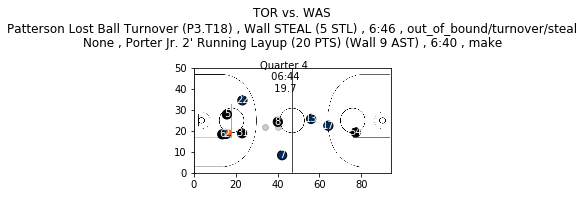

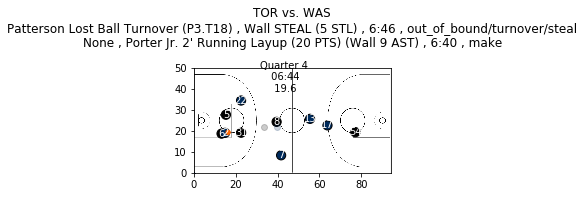

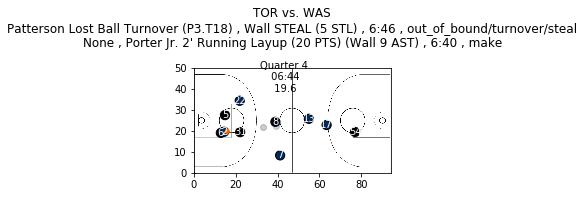

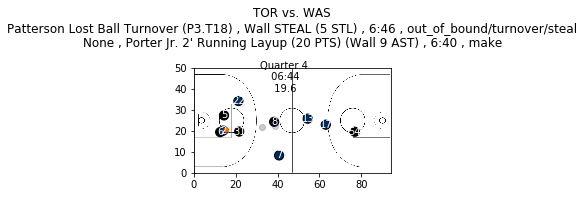

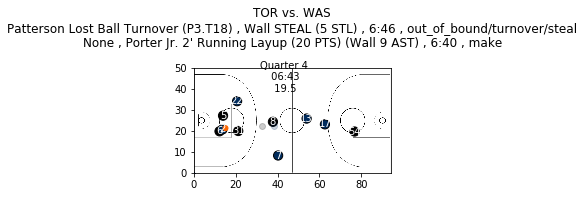

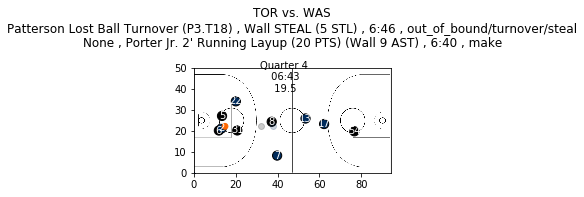

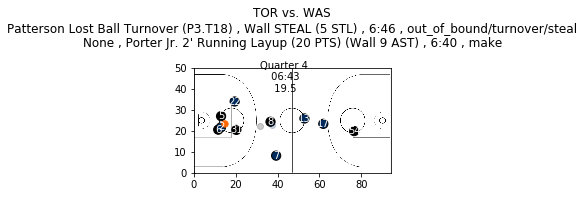

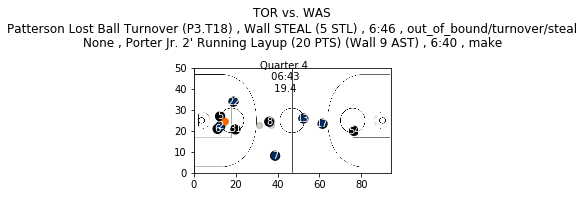

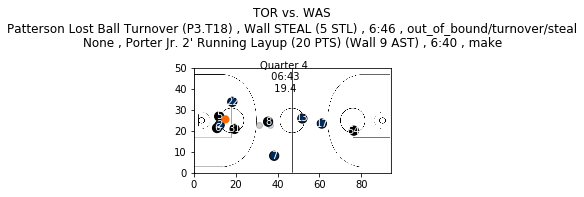

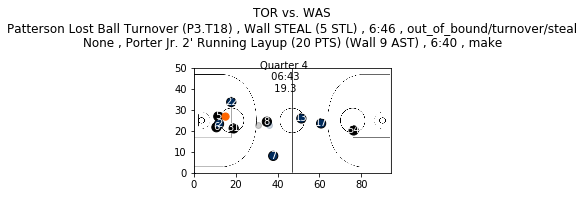

In [233]:
event = 211
moment_count = 519
difference = 5
for i in xrange((moment_count-difference),(moment_count+difference)):
    draw_court(event, i)

In [291]:

print home_team, away_team
prev = pd.DataFrame(moment_list[0][5])

compiled = [ball, home, away]
for moment in moment_list:
    curr = np.array(moment[5])
    if curr != prev:
        print 'changed'
        break
    prev = curr
    
    
    
    if prev_time_left_in_game == time_left_in_game and time_stopped == False:
        time_stopped = True
        # print 'time stopped'
        # print prev_time_left_in_game, time_left_in_game
    
    if prev_time_left_in_game != time_left_in_game and time_stopped == True:
        time_stopped = False
        # print prev_time_left_in_game, time_left_in_game, search_time
        if prev_time_left_in_game > search_time - slack_time: #and prev_time_left_in_game < search_time + 1:
            print 'time started'
            print 'time', moment_data[i], time_left_in_game, event_data.time[search_counter]            
            search_counter = search_counter + 1
            time_stopped = False

        attack  time
0   1610612761    24
1   1610612747   229
2   1610612747   377
3   1610612761   478
4   1610612761   651
5   1610612747   670
6   1610612761   682
7   1610612747   703
8   1610612761   763
9   1610612761   792
10  1610612761   828
11  1610612747  1029
12  1610612747  1242
13  1610612747  1318
14  1610612761  1382
15  1610612761  1425
16  1610612761  1582
17  1610612747  1612
18  1610612761  1685
19  1610612761  1763
20  1610612747  1790
21  1610612761  1810
22  1610612747  1878
23  1610612761  1968
24  1610612761  2001
25  1610612747  2068
26  1610612747  2110
27  1610612747  2131
28  1610612747  2201
29  1610612761  2222
30  1610612747  2251
31  1610612761  2269
32  1610612761  2332
33  1610612761  2436
34  1610612747  2542
35  1610612747  2566
36  1610612761  2581
37  1610612747  2600
38  1610612747  2634
39  1610612747  2658
40  1610612761  2792


In [147]:
2805.37 / 60

46.756166666666665